In [2]:
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

In [74]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../../src')
import LocusTools as lt
import PlotTools as pt
import paperPlots as pp

## read Stripe 82 SDSS-Gaia data for plots...   

In [36]:
datafile = '../../data/Stripe82GaiaEDR3.csv'
s82gaia = Table.read(datafile) 
# reddening corrected SDSS colors
df = s82gaia
df['Ar'] = df['AR_val']
C = lt.extcoeff()
for b in ['u', 'g', 'i', 'z']:  
    df['A'+b] = C[b]*df['Ar']  
# and now apply reddening corrections
df['ug'] = df['u_mMed'] - df['g_mMed'] - (df['Au']-df['Ag'])
df['gr'] = df['g_mMed'] - df['r_mMed'] - (df['Ag']-df['Ar'])
df['ri'] = df['r_mMed'] - df['i_mMed'] - (df['Ar']-df['Ai'])
df['iz'] = df['i_mMed'] - df['z_mMed'] - (df['Ai']-df['Az'])
df['gi'] = df['gr'] + df['ri'] 
df['rmag'] = df['r_mMed']
# for plots, wrapped RA
ra = df['ra_gaia'] 
df['raW'] = np.where(ra > 180, ra-360, ra)

In [105]:
## a few subsamples for plots
# u flux limit (and r band - but just one source rejected)
rMax = 22.0
uMin = 12.0 
uMax = 22.0 
flag = (s82gaia['r_mMed']<rMax)&(s82gaia['u_mMed']>uMin)&(s82gaia['u_mMed']<uMax) 
s82gaiaB = s82gaia[flag]
# for fitting MS and giants
flag = (s82gaiaB['gi']>0.2)&(s82gaiaB['gi']<3.5)
s82gaiaPhD = s82gaiaB[flag]
# good parallax distance
piSNR = s82gaia['pi']/s82gaia['piErr']
s82gaiaPi = s82gaia[piSNR > 20]  
print(len(s82gaia), len(s82gaiaB), len(s82gaiaPhD), len(s82gaiaPi))

841200 415279 409312 63102


## locus used for fitting

In [102]:
datafile = '../../data/LocusData/MSandRGBcolors_v1.3.txt'
locus = lt.LSSTsimsLocus(fixForStripe82=True, datafile=datafile)
## select the color range where we expect main sequence and red giants
Lok = locus[(locus['gi']>0.2)&(locus['gi']<3.55)]   # gives MrMax < 15  
# for plotting, sequences for 3 values of FeH
# selecting a few tracks at fixed metallicity
FeH0 =  0.0
FeH1 = -1.0
FeH2 = -2.0
L0 = Lok[(Lok['FeH']>FeH0-0.01)&(Lok['FeH']<FeH0+0.01)]
L1 = Lok[(Lok['FeH']>FeH1-0.01)&(Lok['FeH']<FeH1+0.01)]
L2 = Lok[(Lok['FeH']>FeH2-0.01)&(Lok['FeH']<FeH2+0.01)]

Fixing input Mr-FeH-colors grid to agree with the SDSS v4.2 catalog


## make all paper plots

made plot: plot3diagsData.png


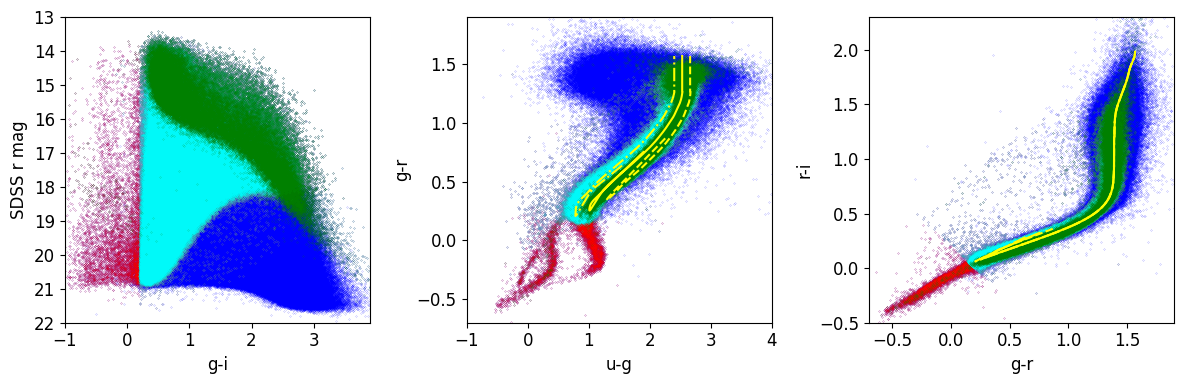

In [106]:
pp.plot3diagsData(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2) 

made plot: plot3HRdiags.png


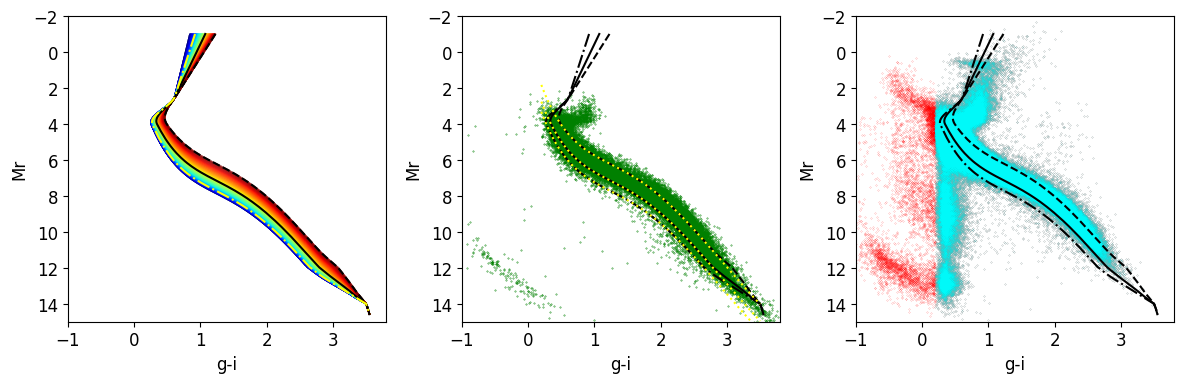

In [108]:
pp.plot3HRdiags(s82gaiaPi, s82gaiaB, s82gaiaPhD, L0, L1, L2, Lok) 
# CBJ outliers with g-i<0.8 and Mr > 7 are faint stars: 19.5 < r < 21.0 (about 10k out of 400k: 2.5%)

## prototype plot versions

Text(0, 0.5, 'Mr')

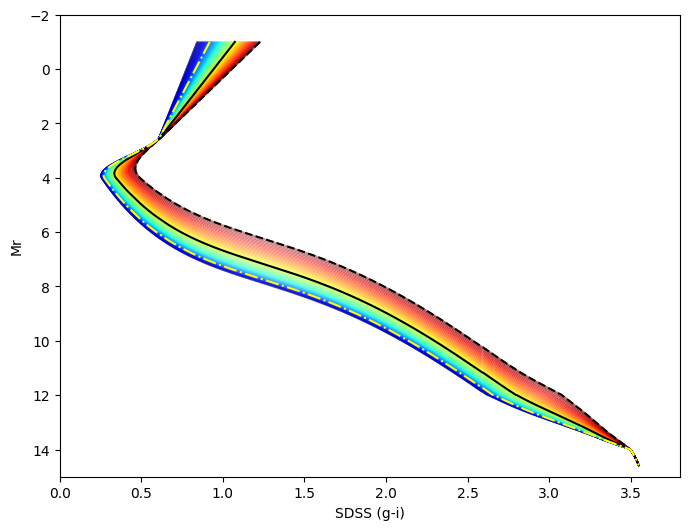

In [63]:
## show Mr vs. g-i relations
fig,ax = plt.subplots(1,1,figsize=(8,6))

# color-coded by FeH
ax.scatter(Lok['gi'], Lok['Mr'], s=0.01, c=Lok['FeH'], cmap=plt.cm.jet)
ax.plot(L0['gi'], L0['Mr'], ls='--', c='black')
ax.plot(L1['gi'], L1['Mr'], ls='-', c='black')
ax.plot(L2['gi'], L2['Mr'], ls='-.', c='yellow')

ax.set_xlim(0.0,3.8)
ax.set_ylim(15.0, -2.0)
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('Mr')

Text(0, 0.5, 'g-r')

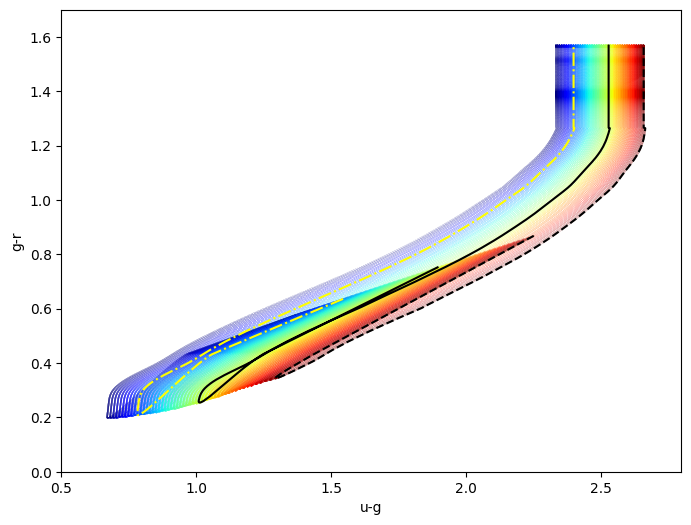

In [67]:
## show Mr vs. g-i relations
fig,ax = plt.subplots(1,1,figsize=(8,6))

# color-coded by FeH
ax.scatter(Lok['ug'], Lok['gr'], s=0.01, c=Lok['FeH'], cmap=plt.cm.jet)
ax.plot(L0['ug'], L0['gr'], ls='--', c='black')
ax.plot(L1['ug'], L1['gr'], ls='-', c='black')
ax.plot(L2['ug'], L2['gr'], ls='-.', c='yellow')

ax.set_xlim(0.5,2.8)
ax.set_ylim(0.0, 1.7)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

Text(0, 0.5, 'r-i')

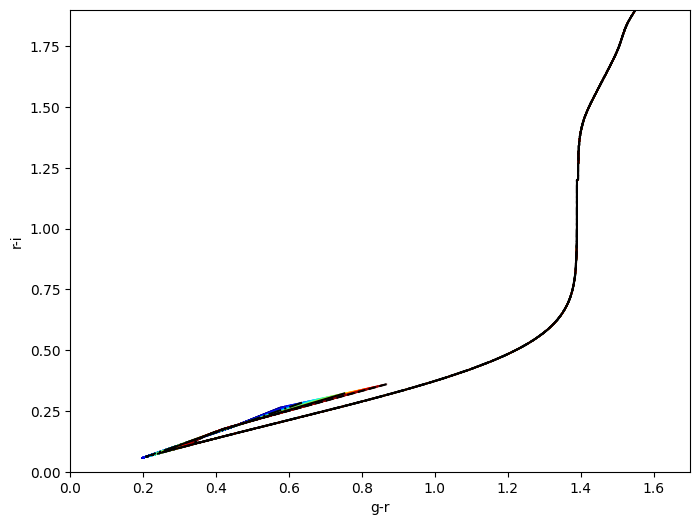

In [72]:
## show Mr vs. g-i relations
fig,ax = plt.subplots(1,1,figsize=(8,6))

# color-coded by FeH
ax.scatter(Lok['gr'], Lok['ri'], s=0.01, c=Lok['FeH'], cmap=plt.cm.jet)
ax.plot(L0['gr'], L0['ri'], ls='--', c='black')
ax.plot(L1['gr'], L1['ri'], ls='-', c='black')
ax.plot(L2['gr'], L2['ri'], ls='-.', c='black')

ax.set_xlim(0.0,1.7)
ax.set_ylim(0.0, 1.9)
ax.set_xlabel('g-r')
ax.set_ylabel('r-i')

Text(0, 0.5, 'Dec. (degree)')

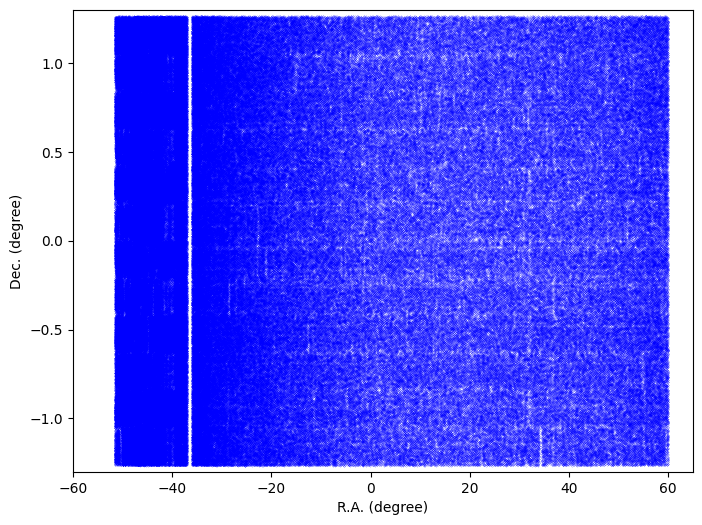

In [40]:
# plot RA-Dec
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['raW'], s82gaia['dec_gaia'], s=0.01, c='blue')
ax.set_xlim(-60,65)
ax.set_ylim(-1.3,1.3)
ax.set_xlabel('R.A. (degree)')
ax.set_ylabel('Dec. (degree)')

Text(0, 0.5, 'r')

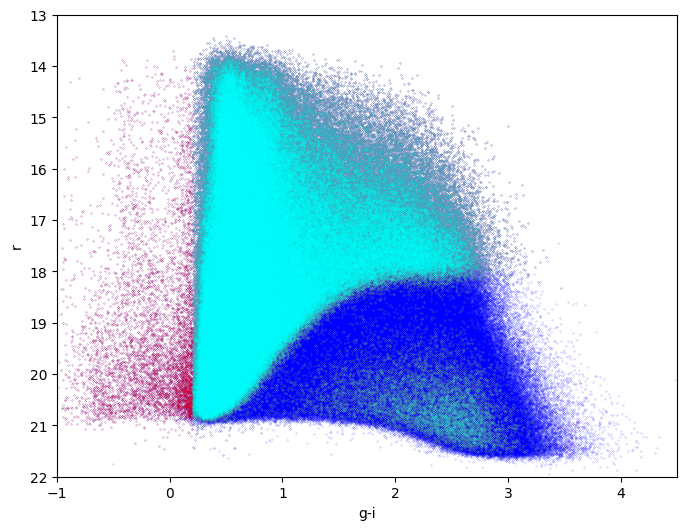

In [61]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['gi'], s82gaia['r_mMed'],s=0.01, c='blue')
ax.scatter(s82gaiaB['gi'], s82gaiaB['r_mMed'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['gi'], s82gaiaPhD['r_mMed'],s=0.01, c='cyan')

ax.set_xlim(-1,4.5)
ax.set_ylim(22,13)
ax.set_xlabel('g-i')
ax.set_ylabel('r')

Text(0, 0.5, 'uErr')

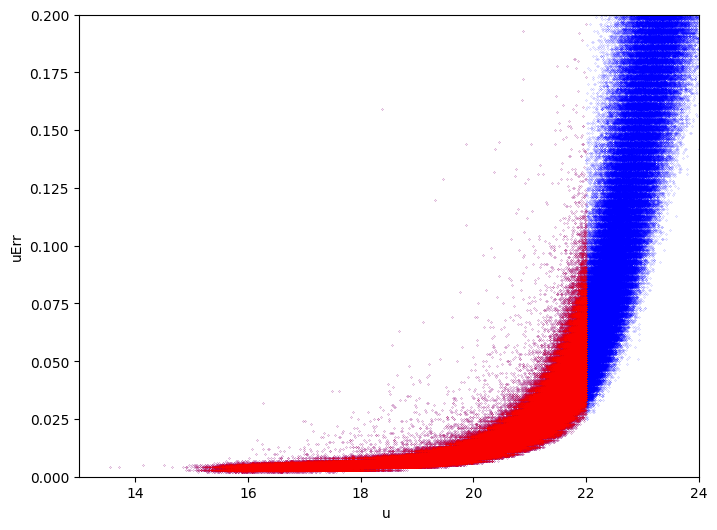

In [42]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['u_mMed'], s82gaia['u_mErr'],s=0.01, c='blue')
ax.scatter(s82gaiaB['u_mMed'], s82gaiaB['u_mErr'],s=0.01, c='red')
ax.set_xlim(13,24.0)
ax.set_ylim(0,0.2)
ax.set_xlabel('u ')
ax.set_ylabel('uErr')

Text(0, 0.5, 'u')

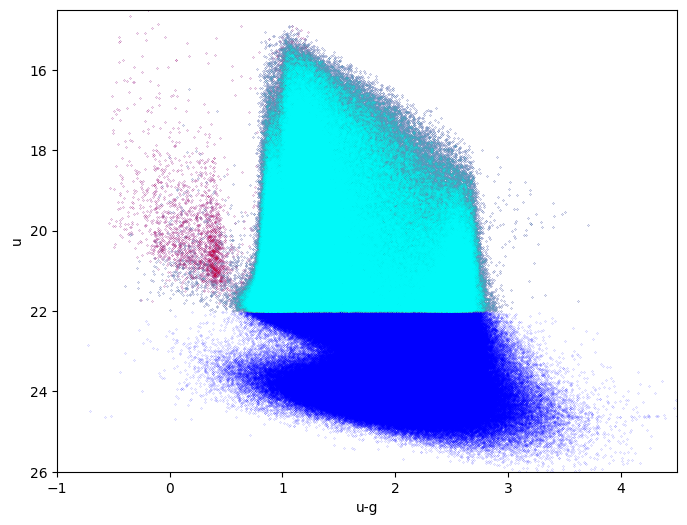

In [60]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['ug'], s82gaia['u_mMed'],s=0.01, c='blue')
ax.scatter(s82gaiaB['ug'], s82gaiaB['u_mMed'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['ug'], s82gaiaPhD['u_mMed'],s=0.01, c='cyan')
ax.set_xlim(-1,4.5)
ax.set_ylim(26,14.5)
ax.set_xlabel('u-g')
ax.set_ylabel('u')

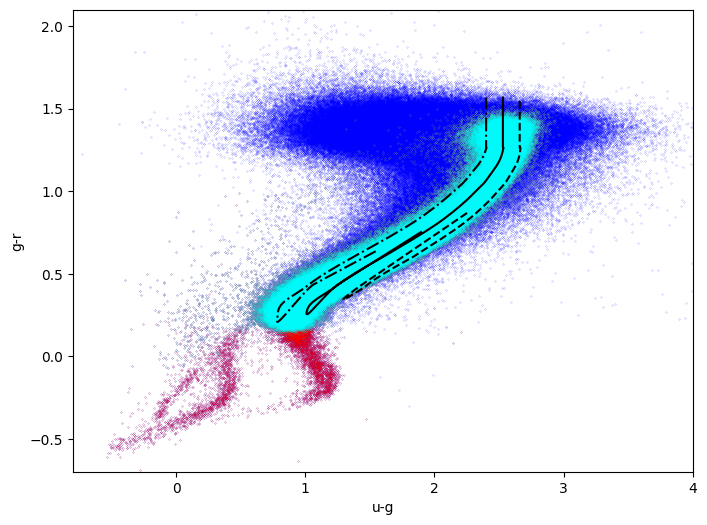

In [58]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['ug'], s82gaia['gr'],s=0.01, c='blue')
ax.scatter(s82gaiaB['ug'], s82gaiaB['gr'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['ug'], s82gaiaPhD['gr'],s=0.01, c='cyan')
ax.set_xlim(-0.8,4.0)
ax.set_ylim(-0.7,2.1)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

# locus
#ax.plot(L0['ug'], L0['gr'], s=0.01, ls='--', c='black')
ax.plot(L0['ug'], L0['gr'], ls='--', c='black')
ax.plot(L1['ug'], L1['gr'], ls='-', c='black')
ax.plot(L2['ug'], L2['gr'], ls='-.', c='black')

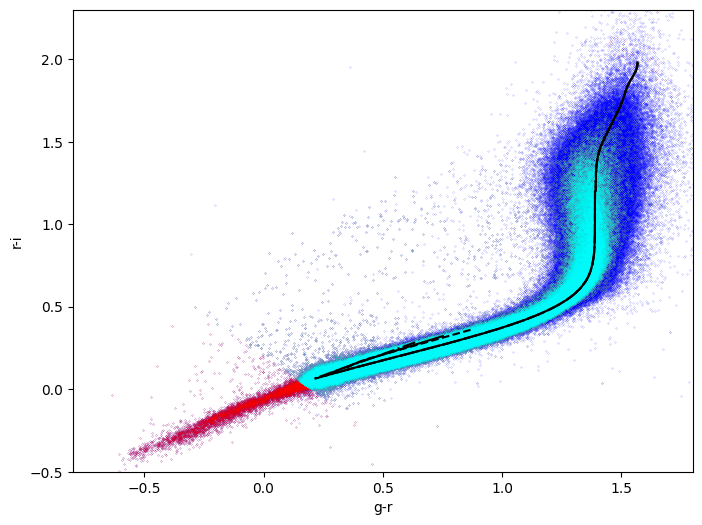

In [45]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['gr'], s82gaia['ri'],s=0.01, c='blue')
ax.scatter(s82gaiaB['gr'], s82gaiaB['ri'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['gr'], s82gaiaPhD['ri'],s=0.01, c='cyan')
ax.set_xlim(-0.8,1.8)
ax.set_ylim(-0.5,2.3)
ax.set_xlabel('g-r')
ax.set_ylabel('r-i')

# locus
ax.plot(L0['gr'], L0['ri'], ls='--', c='black')
ax.plot(L1['gr'], L1['ri'], ls='-', c='black')
ax.plot(L2['gr'], L2['ri'], ls='-.', c='black')

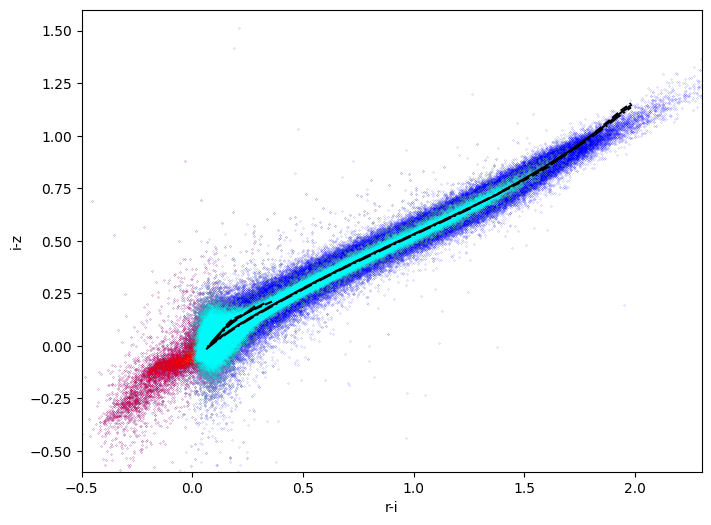

In [46]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['ri'], s82gaia['iz'],s=0.01, c='blue')
ax.scatter(s82gaiaB['ri'], s82gaiaB['iz'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['ri'], s82gaiaPhD['iz'],s=0.01, c='cyan')
ax.set_xlim(-0.5,2.3)
ax.set_ylim(-0.6,1.6)
ax.set_xlabel('r-i')
ax.set_ylabel('i-z')

# locus
ax.plot(L0['ri'], L0['iz'], ls='--', c='black')
ax.plot(L1['ri'], L1['iz'], ls='-', c='black')
ax.plot(L2['ri'], L2['iz'], ls='-.', c='black')

## now look at Gaia's parallax measurements

In [47]:
## how well do distance estimates agree?
s82gaia['dDM'] = s82gaia['DM'] - s82gaia['DMpho'] 
flag1 = (s82gaia['r_mMed']>13.5)&(s82gaia['r_mMed']<21.0)
flag2 = (s82gaia['gi']>-0.5)&(s82gaia['gi']<3.5)
s82gaiaDM = s82gaia[flag1&flag2]
print(np.median(s82gaiaDM['dDM']), np.std(s82gaiaDM['dDM']))

-0.13461343001670123 1.4291047806276724


In [48]:
from astroML.stats import binned_statistic_2d
def sigGzi(x):
    return 0.741*(np.percentile(x,75)-np.percentile(x,25))
    
## here we pixelize the u vs. ug diagram and compute dDM statistics 
gi = s82gaiaDM['gi'] 
rmag = s82gaiaDM['r_mMed'] 
dDM = s82gaiaDM['dDM'] 
N, xedges, yedges = binned_statistic_2d(gi, rmag, dDM, 'count', bins=20)
median, xedges, yedges = binned_statistic_2d(gi, rmag, dDM, 'median', bins=25)
sig, xedges, yedges = binned_statistic_2d(gi, rmag, dDM, sigGzi, bins=25)

In [49]:
cmap_multicolor = plt.cm.jet
cmap_multicolor.set_bad('w', 1.)

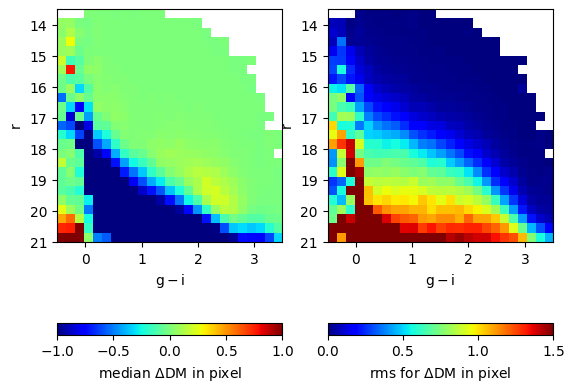

In [50]:
ax = plt.subplot(121)
plt.imshow(median.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor)
plt.xlim(-0.5, 3.5)
plt.ylim(21.0, 13.5)
plt.xlabel(r'$\mathrm{g-i}$')
plt.ylabel(r'$\mathrm{r}$')

cb = plt.colorbar(ticks=np.arange(-1.0, 1.01, 0.5), pad=0.22,
                  format=r'$%.1f$', orientation='horizontal')
cb.set_label(r'$\mathrm{median\ \Delta DM \ in\ pixel}$')
plt.clim(-1.0, 1.0)

ax = plt.subplot(122)
plt.imshow(sig.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor)
plt.xlim(-0.5, 3.5)
plt.ylim(21.0, 13.5)
plt.xlabel(r'$\mathrm{g-i}$')
plt.ylabel(r'$\mathrm{r}$')

cb = plt.colorbar(ticks=np.arange(0, 1.51, 0.5), pad=0.22,
                  format=r'$%.1f$', orientation='horizontal')
cb.set_label(r'$\mathrm{rms \ for \ \Delta DM \ in\ pixel}$')
plt.clim(0, 1.5)

In [51]:
piSNR = s82gaia['pi']/s82gaia['piErr']
s82gaiaPi = s82gaia[piSNR > 20]  
print(len(s82gaiaPi), np.median(s82gaiaPi['dDM']), np.std(s82gaiaPi['dDM']))

63102 0.0018658868709131582 0.02432189999398905


Text(0, 0.5, 'r')

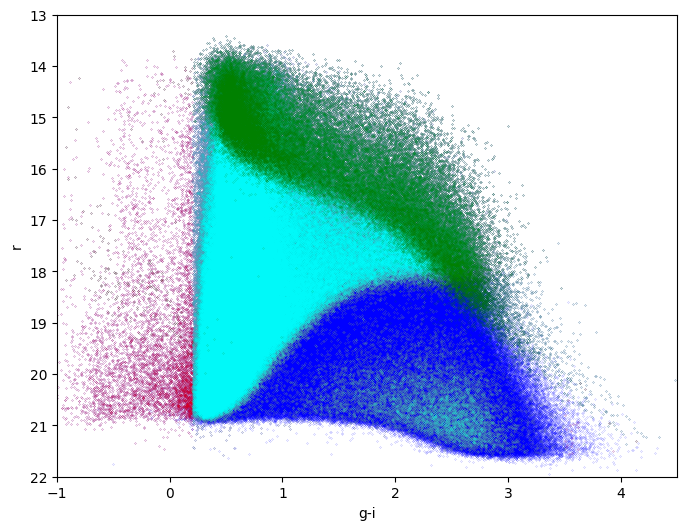

In [52]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['gi'], s82gaia['r_mMed'],s=0.01, c='blue')
ax.scatter(s82gaiaB['gi'], s82gaiaB['r_mMed'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['gi'], s82gaiaPhD['r_mMed'],s=0.01, c='cyan')
ax.scatter(s82gaiaPi['gi'], s82gaiaPi['r_mMed'],s=0.01, c='green')
ax.set_xlim(-1,4.5)
ax.set_ylim(22,13)

ax.set_xlabel('g-i')
ax.set_ylabel('r')

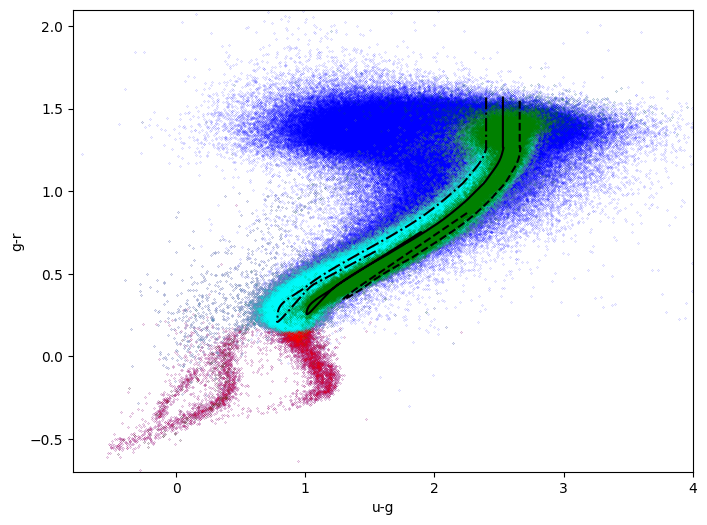

In [53]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaia['ug'], s82gaia['gr'],s=0.01, c='blue')
ax.scatter(s82gaiaB['ug'], s82gaiaB['gr'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['ug'], s82gaiaPhD['gr'],s=0.01, c='cyan')
ax.scatter(s82gaiaPi['ug'], s82gaiaPi['gr'],s=0.01, c='green')
ax.set_xlim(-0.8,4.0)
ax.set_ylim(-0.7,2.1)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

# locus
#ax.plot(L0['ug'], L0['gr'], s=0.01, ls='--', c='black')
ax.plot(L0['ug'], L0['gr'], ls='--', c='black')
ax.plot(L1['ug'], L1['gr'], ls='-', c='black')
ax.plot(L2['ug'], L2['gr'], ls='-.', c='black')

In [54]:
def getMr(gi, FeH):
    MrFit = -5.06 + 14.32*gi -12.97*gi**2 + 6.127*gi**3 -1.267*gi**4 + 0.0967*gi**5
    ## offset for metallicity, valid for -2.5 < FeH < 0.2
    FeHoffset = 4.50 -1.11*FeH -0.18*FeH**2
    return MrFit + FeHoffset

giGrid = np.linspace(0.2, 3.5, 300)
Mr0 = getMr(giGrid, 0.0)
Mr1 = getMr(giGrid, -1.0)
Mr2 = getMr(giGrid, -2.0)

Text(0, 0.5, 'Mr')

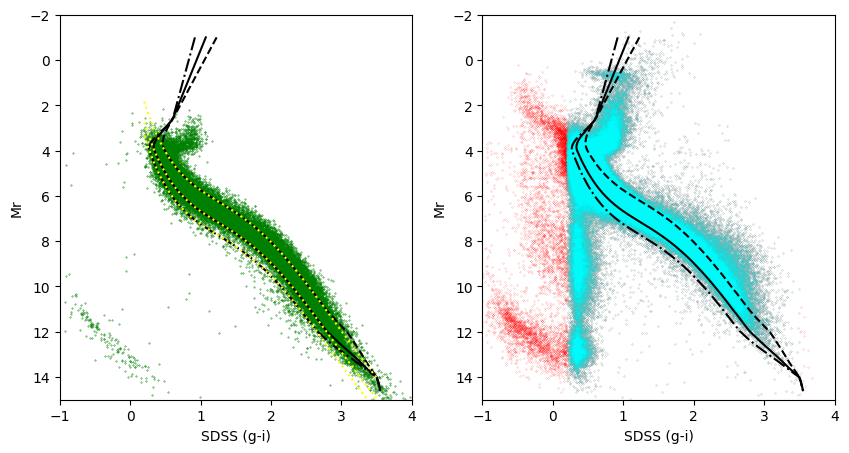

In [55]:
## show Mr vs. g-i relations
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax = plt.subplot(121)
ax.scatter(s82gaiaPi['gi'], s82gaiaPi['Mr'],s=0.1, c='green') 
# ax.scatter(giants['gi'], giants['Mr'],s=0.1, c='red')

# 3 locus sequences
ax.plot(L0['gi'], L0['Mr'], ls='--', c='black')
ax.plot(L1['gi'], L1['Mr'], ls='-', c='black')
ax.plot(L2['gi'], L2['Mr'], ls='-.', c='black')

ax.plot(giGrid, Mr0, ls='dotted', c='yellow')
ax.plot(giGrid, Mr1, ls='dotted', c='yellow')
ax.plot(giGrid, Mr2, ls='dotted', c='yellow')

ax.set_xlim(-1,4.0)
ax.set_ylim(15.0, -2.0)
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('Mr')

ax = plt.subplot(122)
ax.scatter(s82gaiaB['gi'], s82gaiaB['MrPho'],s=0.01, c='red')
ax.scatter(s82gaiaPhD['gi'], s82gaiaPhD['MrPho'],s=0.01, c='cyan')

# 3 locus sequences
ax.plot(L0['gi'], L0['Mr'], ls='--', c='black')
ax.plot(L1['gi'], L1['Mr'], ls='-', c='black')
ax.plot(L2['gi'], L2['Mr'], ls='-.', c='black')
 
ax.set_xlim(-1,4.0)
ax.set_ylim(15.0, -2.0)
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('Mr')

## a closer look at giants...

In [56]:
flag1 = (s82gaiaPi['Mr']>2.5)&(s82gaiaPi['Mr']<4.0)
flag2 = (s82gaiaPi['gi']>0.7)&(s82gaiaPi['gi']<1.1)
giants = s82gaiaPi[flag1&flag2]
print(len(giants), np.median(giants['pi']), np.median(giants['DM']), np.std(giants['DM']))

449 0.6185292294639837 10.900054859754817 0.3262050038387105


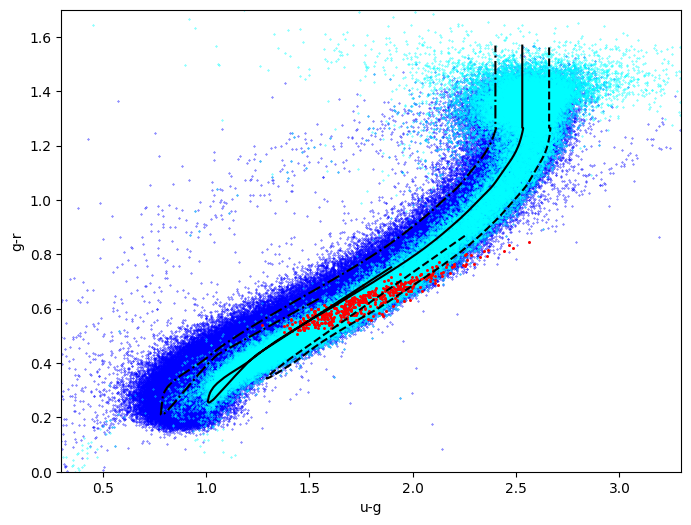

In [57]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(s82gaiaPhD['ug'], s82gaiaPhD['gr'],s=0.1, c='blue')
ax.scatter(s82gaiaPi['ug'], s82gaiaPi['gr'],s=0.1, c='cyan')
ax.scatter(giants['ug'], giants['gr'],s=1.3, c='red')
ax.set_xlim(0.3,3.3)
ax.set_ylim(0.0,1.7)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

# locus
#ax.plot(L0['ug'], L0['gr'], s=0.01, ls='--', c='black')
ax.plot(L0['ug'], L0['gr'], ls='--', c='black')
ax.plot(L1['ug'], L1['gr'], ls='-', c='black')
ax.plot(L2['ug'], L2['gr'], ls='-.', c='black')